In [1]:
import numpy as np
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [4]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

print('Ковариационная матрица:')
print(covariance_matrix)

Собственные значения в порядке убывания:
437.7746724797988
137.10457072021055
22.013531335697195
3.107225464292886
Ковариационная матрица:
[[150.         -17.63546762 130.76306638 122.69116894]
 [-17.63546762 150.         -64.26601565 -54.91888988]
 [130.76306638 -64.26601565 150.         144.42981471]
 [122.69116894 -54.91888988 144.42981471 150.        ]]


In [5]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329987, 22.850761786701778, 3.6689218892828697, 0.5178709107154814]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [6]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [7]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)

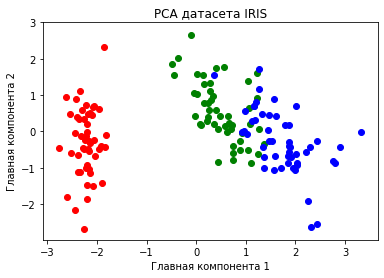

In [8]:
def plot(Z, y):
    plt.figure()
    for c, i in zip("rgb", [0, 1, 2]):
        plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title('PCA датасета IRIS')
    plt.show()
    
plot(Z, iris.target)

## ДЗ: 

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_, iris.target, test_size=0.2, random_state=1)

In [10]:
# Задание 1 -  Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции

# svd-разложение, возвращает матрицу подпространства W для кумулятивной доли дисперсии >= min_var 
def svd_pca(X, min_var):
    U, s, W = np.linalg.svd(X_train)
    eig_values = s * s
    cum_var_values = np.cumsum(eig_values / np.sum(eig_values))
    i = np.argmax(cum_var_values >= min_var)
    return W.T[:, 0:(i + 1)]


In [11]:
W = svd_pca(X_train, 0.95)
W

array([[-0.52931569,  0.33308299],
       [ 0.23698255,  0.9403434 ],
       [-0.58048601,  0.01311446],
       [-0.57157691,  0.0681031 ]])

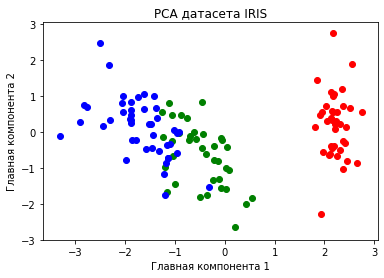

In [12]:
plot(X_train.dot(W), y_train)

In [17]:
# Задание 2 - Обучить любую модель классификации на датасете IRIS до применения PCA и после него. 
# Сравнить качество классификации по отложенной выборке.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

def train_and_test(X_train, y_train, X_test, y_test):
    print("X_train.shape: ", X_train.shape)
    print("X_test.shape: ", X_test.shape)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    train_predicted = model.predict(X_train)
    test_predicted = model.predict(X_test)
    train_error = balanced_accuracy_score(y_train, train_predicted)
    test_error = balanced_accuracy_score(y_test, test_predicted)
    print(f"Train error: {train_error:0.5}, Test error: {test_error:0.5}")



In [25]:
# до PCA:
train_and_test(X_train, y_train, X_test, y_test)
# после PCA:
train_and_test(X_train.dot(W), y_train, X_test.dot(W), y_test)

X_train.shape:  (120, 4)
X_test.shape:  (30, 4)
Train error: 1.0, Test error: 0.97436
X_train.shape:  (120, 2)
X_test.shape:  (30, 2)
Train error: 1.0, Test error: 0.97436


## Выводы:
* Мы уже делали похожее задание в курсе линейной алгебры, как раз для ириса. Пришлось только немного доработать код для отбора по кумулятивной дисперсии. SVD-разложение удобно тем, что самое сортирует сингулярные значения, которые являются собственными значениями ковариационной матрицы. 
* Удалось уменьшить число признаков до 2х из подпространства V без потери точности (иногда случайно неправильно предсказывался один элемент, что приводит к снижению метрики до 0.94)